# **3. Neural Nets**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 16

## **Prediksi karyawan left (1) atau tidak (0)**

*Cek Resiko dengan Sederhana*

- Salah prediksi karyawan stay - diprediksi stay, padahal resign/left
  - Resource bisa berkurang sehingga produktifitas menurun
  - Mengeluarkan cost untuk pesangon karyawan
  - Ada kemungkinan beberapa target tidak terkejar

- Salah prediksi karyawan left - diprediksi left, padahal stay
  - Sudah membuka job opening lebih dulu, HR bisa buang-buang waktu.
  - Mungkin melakukan restrukturisasi tim.

---
- Lebih besar resiko dari salah prediksi karyawan stay
- Apabila stay = negative (0) & left = positive (1)
- Maka kita ingin memperkecil nilai False Negative
- Dengan kata lain memperbesar nilai Recall

$$
\text{Recall} = \cfrac{TP}{TP + FN}
$$

**Import Data**

In [2]:
def importData(filename):
    # Read Data
    data = pd.read_csv(filename)
    print(f"shape awal                    : {data.shape}, (#observasi, #fitur)")

    # Drop duplicate
    data = data.drop_duplicates()
    print(f"shape setelah drop duplikat   : {data.shape}, (#observasi, #fitur)")

    return data


In [3]:
filename = "../data/data_hr.csv"
data = importData(filename = filename)

data.head()

shape awal                    : (14999, 10), (#observasi, #fitur)
shape setelah drop duplikat   : (11991, 10), (#observasi, #fitur)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,division,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


**Split Data Input-Ouput**

In [4]:
def splitInputOutput(data, target_column):
    X = data.drop(columns = target_column)
    y = data[target_column]

    return X, y

In [5]:
target_column = "left"
X, y = splitInputOutput(data = data,
                        target_column = target_column)

X.head, y.head

(<bound method NDFrame.head of        satisfaction_level  last_evaluation  number_project  \
 0                    0.38             0.53               2   
 1                    0.80             0.86               5   
 2                    0.11             0.88               7   
 3                    0.72             0.87               5   
 4                    0.37             0.52               2   
 ...                   ...              ...             ...   
 11995                0.90             0.55               3   
 11996                0.74             0.95               5   
 11997                0.85             0.54               3   
 11998                0.33             0.65               3   
 11999                0.50             0.73               4   
 
        average_montly_hours  time_spend_company  Work_accident  \
 0                       157                   3              0   
 1                       262                   6              0   
 2         

**Split Train-Test**

In [6]:
# Cek kondisi proporsi kelas target
y.value_counts(normalize = True)

# Tidak balance

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 9), (2399, 9), (9592,), (2399,))

**Splitting Categorical & Numerical Column**

In [8]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,division,salary
9492,0.44,0.56,3,123,3,0,0,accounting,medium
11555,0.98,0.44,4,154,6,1,0,sales,medium
11301,0.76,0.99,3,133,4,0,0,sales,low
5578,0.47,0.55,2,156,2,0,0,management,medium
6241,0.84,0.68,4,151,2,0,0,technical,low


In [9]:
categorical_col = ["Work_accident", "promotion_last_5years", "division", "salary"]
numerical_col = list(set(X_train.columns) - set(categorical_col))

categorical_col, numerical_col

(['Work_accident', 'promotion_last_5years', 'division', 'salary'],
 ['number_project',
  'time_spend_company',
  'satisfaction_level',
  'average_montly_hours',
  'last_evaluation'])

In [10]:
def splitNumCat(data, num_col, cat_col):
    data_num = data[num_col]
    data_cat = data[cat_col]

    return data_num, data_cat


In [11]:
X_train_num, X_train_cat = splitNumCat(data = X_train,
                                       num_col = numerical_col,
                                       cat_col = categorical_col)

**Handling Numerical Data**

In [12]:
# Check missing value
X_train_num.isna().any()

number_project          False
time_spend_company      False
satisfaction_level      False
average_montly_hours    False
last_evaluation         False
dtype: bool

In [13]:
# Buat imputer untuk jaga-jaga apabila di data test ada yang kosong
from sklearn.impute import SimpleImputer

def imputerNum(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "median")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)

    return data_imputed, imputer


In [14]:
X_train_num_imputed, imputer_num = imputerNum(data = X_train_num)

In [15]:
X_train_num_imputed.head()

,number_project,time_spend_company,satisfaction_level,average_montly_hours,last_evaluation
9492,3.0,3.0,0.44,123.0,0.56
11555,4.0,6.0,0.98,154.0,0.44
11301,3.0,4.0,0.76,133.0,0.99
5578,2.0,2.0,0.47,156.0,0.55
6241,4.0,2.0,0.84,151.0,0.68


**Handling Categorical Data**

In [16]:
# Check missing value
X_train_cat.isna().any()

Work_accident            False
promotion_last_5years    False
division                 False
salary                   False
dtype: bool

In [17]:
# Buat imputer untuk jaga-jaga apabila di data test ada yang kosong
def imputerCat(data, imputer = None):
    if imputer == None:
        # Buat imputer
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "constant",
                                fill_value = "UNKNOWN")
        imputer.fit(data)

    # Transform data dengan imputer
    data_imputed = imputer.transform(data)
    data_imputed = pd.DataFrame(data_imputed,
                                index = data.index,
                                columns = data.columns)

    return data_imputed, imputer


In [18]:
X_train_cat_imputed, imputer_cat = imputerCat(data = X_train_cat)

In [19]:
X_train_cat_imputed.head()

,Work_accident,promotion_last_5years,division,salary
9492,0,0,accounting,medium
11555,1,0,sales,medium
11301,0,0,sales,low
5578,0,0,management,medium
6241,0,0,technical,low


**One Hot Encoding Data**

In [20]:
from sklearn.preprocessing import OneHotEncoder

def encoderCat(data, encoder_col = None, encoder = None):
    if encoder == None:
        # Buat objek
        encoder = OneHotEncoder(handle_unknown = "ignore",
                                drop = "if_binary")
        encoder.fit(data)
        encoder_col = encoder.get_feature_names_out(data.columns)

    # Transform data
    data_encoded = encoder.transform(data).toarray()
    data_encoded = pd.DataFrame(data_encoded,
                                index = data.index,
                                columns = encoder_col)

    return data_encoded, encoder_col, encoder


In [21]:
X_train_cat_encoded, encoder_col, encoder_OHE = encoderCat(data = X_train_cat_imputed)

In [22]:
X_train_cat_imputed.head().T

,9492,11555,11301,5578,6241
Work_accident,0,1,0,0,0
promotion_last_5years,0,0,0,0,0
division,accounting,sales,sales,management,technical
salary,medium,medium,low,medium,low


In [23]:
X_train_cat_encoded.head().T

,9492,11555,11301,5578,6241
Work_accident_1,0.0,1.0,0.0,0.0,0.0
promotion_last_5years_1,0.0,0.0,0.0,0.0,0.0
division_IT,0.0,0.0,0.0,0.0,0.0
division_RandD,0.0,0.0,0.0,0.0,0.0
division_accounting,1.0,0.0,0.0,0.0,0.0
division_hr,0.0,0.0,0.0,0.0,0.0
division_management,0.0,0.0,0.0,1.0,0.0
division_marketing,0.0,0.0,0.0,0.0,0.0
division_product_mng,0.0,0.0,0.0,0.0,0.0
division_sales,0.0,1.0,1.0,0.0,0.0


In [24]:
encoder_col

array(['Work_accident_1', 'promotion_last_5years_1', 'division_IT',
       'division_RandD', 'division_accounting', 'division_hr',
       'division_management', 'division_marketing',
       'division_product_mng', 'division_sales', 'division_support',
       'division_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype=object)

**Concat Data**

In [25]:
X_train_concat = pd.concat([X_train_num_imputed, X_train_cat_encoded],
                           axis = 1)
X_train_concat.head()

,number_project,time_spend_company,satisfaction_level,average_montly_hours,last_evaluation,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
9492,3.0,3.0,0.44,123.0,0.56,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11555,4.0,6.0,0.98,154.0,0.44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11301,3.0,4.0,0.76,133.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5578,2.0,2.0,0.47,156.0,0.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6241,4.0,2.0,0.84,151.0,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Balancing Data: SMOTE**

In [26]:
# Cek missing values
X_train_concat.isna().any()

number_project             False
time_spend_company         False
satisfaction_level         False
average_montly_hours       False
last_evaluation            False
Work_accident_1            False
promotion_last_5years_1    False
division_IT                False
division_RandD             False
division_accounting        False
division_hr                False
division_management        False
division_marketing         False
division_product_mng       False
division_sales             False
division_support           False
division_technical         False
salary_high                False
salary_low                 False
salary_medium              False
dtype: bool

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
y_train.value_counts()

left
0    7999
1    1593
Name: count, dtype: int64

In [29]:
# Buat objek
smt = SMOTE(sampling_strategy = "minority",
            random_state = 123)

# Fit objek
X_train_smote, y_train = smt.fit_resample(X_train_concat, y_train)

/home/ubuntu/learning/natural-language-processing/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/ubuntu/learning/natural-language-processing/.venv/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [30]:
y_train.value_counts()

left
0    7999
1    7999
Name: count, dtype: int64

**Scale Data**

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
def standardizeData(data, scaler = None):
    if scaler == None:
        # Buat & Fit scaler
        scaler = StandardScaler()
        scaler.fit(data)

    # Tranform data
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled,
                               index = data.index,
                               columns = data.columns)

    return data_scaled, scaler


In [33]:
X_train_clean, scaler = standardizeData(data = X_train_smote)
X_train_clean.head()

,number_project,time_spend_company,satisfaction_level,average_montly_hours,last_evaluation,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,-0.578222,-0.471180,-0.431520,-1.486431,-0.890688,-0.351352,-0.110301,-0.29791,-0.235689,4.610671,-0.249149,-0.185290,-0.256439,-0.255945,-0.658190,-0.442027,-0.502668,-0.244253,-1.077772,1.203620
1,0.111005,2.009388,1.603535,-0.914856,-1.560949,2.972531,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,-0.185290,-0.256439,-0.255945,1.620948,-0.442027,-0.502668,-0.244253,-1.077772,1.203620
2,-0.578222,0.355676,0.774438,-1.302052,1.511078,-0.351352,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,-0.185290,-0.256439,-0.255945,1.620948,-0.442027,-0.502668,-0.244253,0.954531,-0.853654
3,-1.267449,-1.298037,-0.318461,-0.877981,-0.946543,-0.351352,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,5.980862,-0.256439,-0.255945,-0.658190,-0.442027,-0.502668,-0.244253,-1.077772,1.203620
4,0.111005,-1.298037,1.075928,-0.970170,-0.220428,-0.351352,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,-0.185290,-0.256439,-0.255945,-0.658190,-0.442027,2.138074,-0.244253,0.954531,-0.853654


**Transform Test Data**

In [34]:
def transformTestData(data, num_col, cat_col, encoder_col,
                      imputer_num, imputer_cat, encoder_cat,
                      scaler):
    # 1. Split num-cat
    data_num, data_cat = splitNumCat(data = data,
                                     num_col = num_col,
                                     cat_col = cat_col)

    # 2. Handling num
    data_num_imputed, _ = imputerNum(data = data_num,
                                     imputer = imputer_num)

    # 3. Handling cat
    data_cat_imputed, _ = imputerCat(data = data_cat,
                                     imputer = imputer_cat)
    data_cat_encoded, _, _ = encoderCat(data = data_cat_imputed,
                                        encoder_col = encoder_col,
                                        encoder = encoder_cat)

    # 4. Concat data
    data_concat = pd.concat([data_num_imputed, data_cat_encoded],
                            axis = 1)

    # 5. Scale data
    data_clean, _ = standardizeData(data = data_concat,
                                    scaler = scaler)

    return data_clean


In [35]:
X_test_clean = transformTestData(data = X_test,
                                 num_col = numerical_col,
                                 cat_col = categorical_col,
                                 encoder_col = encoder_col,
                                 imputer_num = imputer_num,
                                 imputer_cat = imputer_cat,
                                 encoder_cat = encoder_OHE,
                                 scaler = scaler)

X_test_clean.head()

,number_project,time_spend_company,satisfaction_level,average_montly_hours,last_evaluation,Work_accident_1,promotion_last_5years_1,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
8578,1.489460,2.009388,1.000556,-0.232655,1.287658,-0.351352,-0.110301,-0.29791,-0.235689,4.610671,-0.249149,-0.18529,-0.256439,-0.255945,-0.658190,-0.442027,-0.502668,-0.244253,-1.077772,1.20362
5756,0.800233,0.355676,-1.411361,1.168624,0.784963,-0.351352,-0.110301,-0.29791,-0.235689,4.610671,-0.249149,-0.18529,-0.256439,-0.255945,-0.658190,-0.442027,-0.502668,-0.244253,-1.077772,1.20362
3994,0.111005,-1.298037,0.284518,-0.804229,1.455223,-0.351352,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,-0.18529,-0.256439,-0.255945,1.620948,-0.442027,-0.502668,-0.244253,-1.077772,1.20362
1784,-1.267449,-0.471180,-0.469206,-1.007046,-1.169963,2.972531,-0.110301,-0.29791,-0.235689,4.610671,-0.249149,-0.18529,-0.256439,-0.255945,-0.658190,-0.442027,-0.502668,-0.244253,-1.077772,1.20362
10508,0.111005,-0.471180,-0.167717,0.762991,1.455223,-0.351352,-0.110301,-0.29791,-0.235689,-0.241612,-0.249149,-0.18529,-0.256439,-0.255945,-0.658190,2.442235,-0.502668,-0.244253,-1.077772,1.20362


In [36]:
X_test_clean.columns

Index(['number_project', 'time_spend_company', 'satisfaction_level',
       'average_montly_hours', 'last_evaluation', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [37]:
X_train_clean.columns

Index(['number_project', 'time_spend_company', 'satisfaction_level',
       'average_montly_hours', 'last_evaluation', 'Work_accident_1',
       'promotion_last_5years_1', 'division_IT', 'division_RandD',
       'division_accounting', 'division_hr', 'division_management',
       'division_marketing', 'division_product_mng', 'division_sales',
       'division_support', 'division_technical', 'salary_high', 'salary_low',
       'salary_medium'],
      dtype='object')

In [38]:
len(X_train_clean.columns)

20

*Done*

---
# Multi-Layer Perceptron (Neural Network)

- Mengadaptasi cara sel otak transfer & mengolah informasi.
- Satuan terkecilnya adalah Neuron (Perceptron)

<center>
<img src="../assets/neural_nets/neural_nets.png">
<br>
<a href="https://media.datacamp.com/legacy/v1725638284/image_bd3b978959.png">source</a>
</center>

- 1 Perceptron dapat menerima beberapa input
- 1 Perceptron mengeluarkan 1 output
- Input-input akan dijumlahkan secara berbobot dahulu (`preActivation`)
- Kemudian akan diaktifasi menggunakan `activation function` seperti Sigmoid, ReLU, TanH, dan sebagainya.

---
## Feed Propagation
- Misal kita ingin selesaikan kasus klasifikasi
- Kita buat arsitektur Neural Network dengan 1 perceptron

In [39]:
def preActivation(X, w):
    """
    Fungsi untuk mendapatkan nilai pre activation (weighted-sum)
    :param X: <pandas DataFrame> data input
    :param w: <numpy array> weight dari masing-masing input
    :return a: <numpy array> weighted sum atau pre activation
    """
    a = np.dot(X, w[1:]) + w[0]

    return a

In [40]:
def activationFunction(a, types):
    """
    Fungsi untuk melakukan aktifasi nilai pre activation
    :param a: <numpy array> pre activation value
    :param types: <str> pilihan fungsi aktivasi
    :return y: <numpy array> output perceptron
    """
    if types == "linear":
        y = a
    elif types == "sigmoid":
        y = 1 / (1 + np.exp(-a))
    elif types == "relu":
        y = np.max(0, a)
    else:
        raise Exception("Activation Function tidak terdaftar")

    return y

*Lakukan Forward Propagation*

In [41]:
# Buat random weight
# Ada 20 weight & 1 bias
w = np.random.rand(21)
w

array([0.26275763, 0.5019218 , 0.68190836, 0.80361018, 0.67916032,
       0.36425425, 0.48030902, 0.00429445, 0.4374751 , 0.6915018 ,
       0.83718154, 0.28470988, 0.80999857, 0.71628825, 0.03143616,
       0.18191245, 0.43899483, 0.22834847, 0.02807022, 0.52974836,
       0.24303325])

*pada data train*

In [42]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w)

In [43]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

In [44]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

*pada data test*

In [45]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w)

In [46]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [47]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

In [48]:
# Cari performa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

*pada data train*

In [49]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[3614, 4385],
       [3688, 4311]])

In [50]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.49537442180272534

In [51]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.49      0.45      0.47      7999
    left (1)       0.50      0.54      0.52      7999

    accuracy                           0.50     15998
   macro avg       0.50      0.50      0.49     15998
weighted avg       0.50      0.50      0.49     15998



**Baseline**
- karena data sudah balance, accuracy baseline adalah 50%
- model ini lebih buruk dibanding baseline, jadi harus diimprove

**Focus**
- `weighted_avg recall` bernilai 0.49, artinya dari yang **benar-benar** left, hanya 49% yang berhasil diprediksi left.
- Berarti masih ada hampir 50% karyawan yang left tapi salah prediksi, dengan kata lain resikonya besar.
- Kita ingin kecilkan hal tersebut

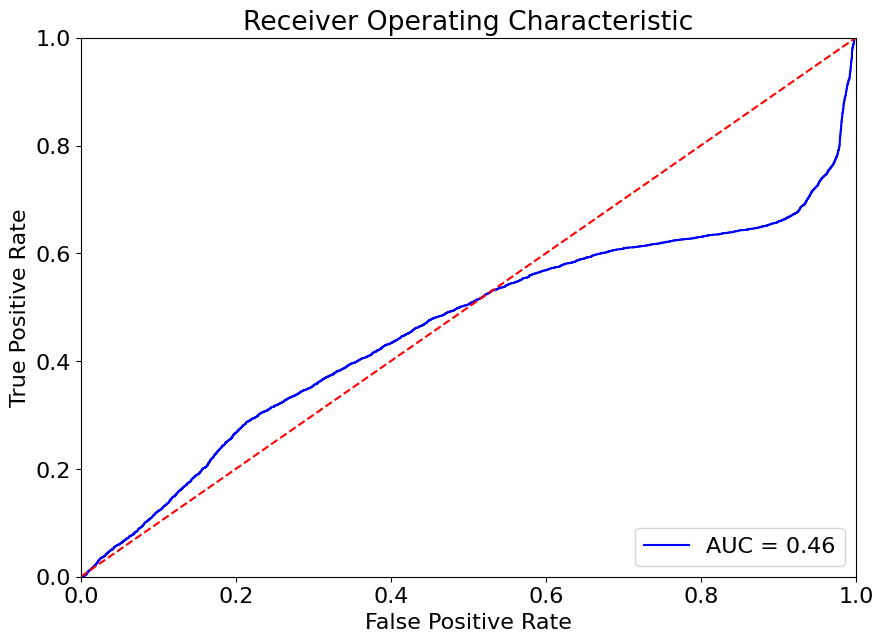

In [52]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [53]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[ 878, 1123],
       [ 179,  219]])

In [54]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.45727386411004584

In [55]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.83      0.44      0.57      2001
    left (1)       0.16      0.55      0.25       398

    accuracy                           0.46      2399
   macro avg       0.50      0.49      0.41      2399
weighted avg       0.72      0.46      0.52      2399



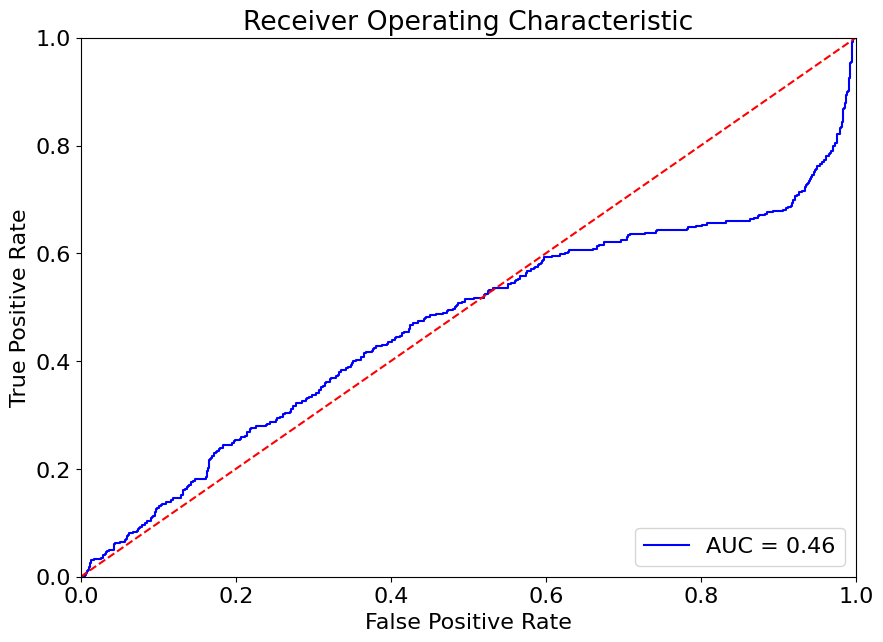

In [56]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Masih jelek, ingin kita improve

---
# Gradient Descent

- Akurasi model random masih kecil, ingin kita tingkatkan
- Artinya, **weight** ingin kita optimasi
- Dapat dioptimasi menggunakan **Gradient Descent**

<center>
<img src="https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning1.png">
<br>
<a href="https://www.javatpoint.com/gradient-descent-in-machine-learning">source</a>
</center>

Algoritma:
- Inisialisasi weight, *bisa random*
- Cari gradient error terhadap weight
- Lakukan update weight dari informasi gradient tersebut

$$
w_{\text{new}} = w_{\text{old}} - \nabla_{w} E
$$

- Ulangi hingga stopping criteria tercapai (max. iteration atau weight tidak berubah --> $\nabla_{w} E = 0$)

---
# Backpropagation & Gradient Descent

$$
\begin{align*}
a^{(i)} &= w_{0} + w_{1}x_{1}^{(i)} + w_{2}x_{2}^{(i)} + \cdots + w_{20}x_{20}^{(i)} \\
\hat{y}^{(i)} &= \sigma (a^{(i)}) = \cfrac{1}{1 + \exp(-a^{(i)})}\\
\text{error}^{(i)} &= (y^{(i)} - \hat{y}^{(i)})^{2}
\end{align*}
$$

Cari gradient error menggunakan chain rules

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial w_{0}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{0}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{1}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{1}} \\ \\
\cfrac{\partial \text{error}}{\partial w_{2}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{2}} \\ \\
\vdots \\ \\
\cfrac{\partial \text{error}}{\partial w_{20}} &= \cfrac{\partial \text{error}}{\partial \hat{y}} \cdot \cfrac{\partial \hat{y}}{\partial a} \cdot \cfrac{\partial a}{\partial w_{20}}
\end{align*}
$$

Maka didapat

$$
\begin{align*}
\cfrac{\partial \text{error}}{\partial \hat{y}} &= -2 (y - \hat{y}) \\ \\
\cfrac{\partial \hat{y}}{\partial a} &= \sigma(a)(1 - \sigma(a)) \\ \\
\cfrac{\partial a}{\partial w_{0}} &= 1 \\ \\
\cfrac{\partial a}{\partial w_{1}} &= x_{1} \\ \\
\cfrac{\partial a}{\partial w_{2}} &= x_{2} \\ \\
\vdots \\ \\
\cfrac{\partial a}{\partial w_{20}} &= x_{20}
\end{align*}
$$

In [57]:
def gradientDescent(X, y,
                    learning_rate, max_iter,
                    epsilon = 1e-6):
    """
    Fungsi untuk melakukan update weight
    """
    X = np.array(X)
    n = X.shape[0]          # banyak data
    p = X.shape[1] + 1      # banyak parameter

    # Inisialisasi weights
    w = np.ones(p)

    # Inisialisasi
    w_hist = []
    loss_hist = []
    iter = 0
    previous_loss = 0

    # Lakukan iterasi
    for iter in range(max_iter):
        # Buat prediksi
        a = preActivation(X = X, w = w)
        y_pred = activationFunction(a = a, types = "sigmoid")

        # Cari error
        current_loss = np.linalg.norm(y - y_pred)**2

        if np.abs(previous_loss - current_loss) < epsilon:
            break

        # Update
        previous_loss = current_loss
        loss_hist.append(current_loss)
        w_hist.append(w)

        # Cari gradient error
        derr_dy = -2 * (y - y_pred)
        dy_da = y_pred * (1 - y_pred)

        derr_dw = np.zeros(p)
        for j in range(p):
            # Cari da_dw_j
            if j == 0:
                da_dw = np.ones(n)
            else:
                da_dw = X[:, j-1]

            # Cari error
            derr_dw[j] = np.sum(derr_dy * dy_da * da_dw)


        # Update weight dari gradient error
        for j in range(p):
            w[j] = w[j] - learning_rate * derr_dw[j]

        if iter%100 == 0:
            print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    # Print last iteration
    print(f"iterasi {iter+1} - Loss: {current_loss:.4f}")

    return loss_hist, w_hist

In [58]:
loss_hist, w_hist = gradientDescent(X = X_train_clean,
                                    y = y_train,
                                    learning_rate = 0.01,
                                    max_iter = 5000)

iterasi 1 - Loss: 7488.0234
iterasi 101 - Loss: 2016.9170
iterasi 201 - Loss: 2011.2898
iterasi 301 - Loss: 1996.1502
iterasi 401 - Loss: 1990.9004
iterasi 501 - Loss: 1989.6204
iterasi 601 - Loss: 1988.8604
iterasi 701 - Loss: 1988.3137
iterasi 801 - Loss: 1987.9106
iterasi 901 - Loss: 1987.6088
iterasi 1001 - Loss: 1987.3803
iterasi 1101 - Loss: 1987.2059
iterasi 1201 - Loss: 1987.0720
iterasi 1301 - Loss: 1986.9686
iterasi 1401 - Loss: 1986.8885
iterasi 1501 - Loss: 1986.8262
iterasi 1601 - Loss: 1986.7778
iterasi 1701 - Loss: 1986.7400
iterasi 1801 - Loss: 1986.7105
iterasi 1901 - Loss: 1986.6874
iterasi 2001 - Loss: 1986.6693
iterasi 2101 - Loss: 1986.6552
iterasi 2201 - Loss: 1986.6441
iterasi 2301 - Loss: 1986.6354
iterasi 2401 - Loss: 1986.6286
iterasi 2501 - Loss: 1986.6233
iterasi 2601 - Loss: 1986.6191
iterasi 2701 - Loss: 1986.6158
iterasi 2801 - Loss: 1986.6132
iterasi 2901 - Loss: 1986.6112
iterasi 3001 - Loss: 1986.6096
iterasi 3101 - Loss: 1986.6084
iterasi 3201 - Loss:

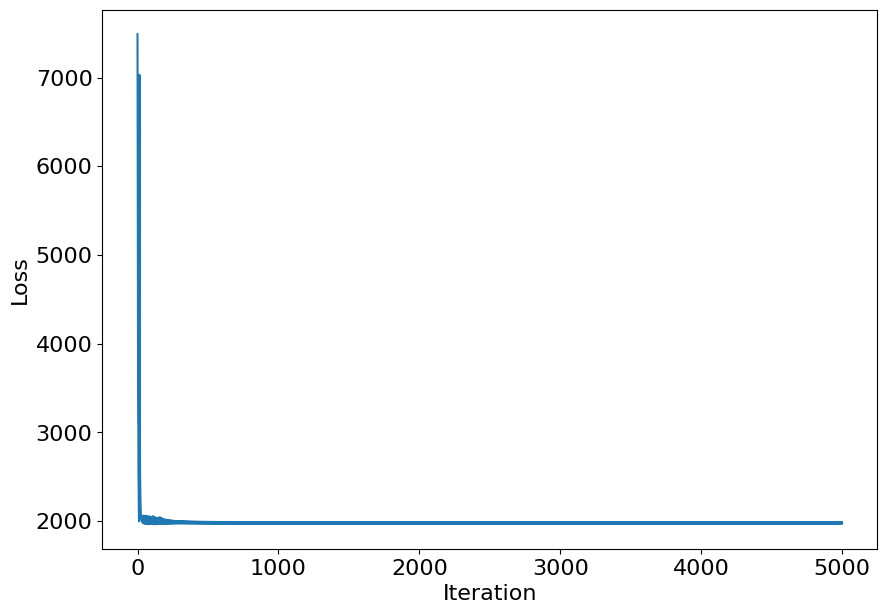

In [59]:
# Plot Error history
plt.plot([i for i in range(len(loss_hist))], loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

In [60]:
# Cari best weights
w_best = w_hist[-1]
w_best

array([ -2.29865596,  -7.45527133,  18.16754857, -10.64140682,
        -0.41842444,   0.46063444,  -0.68579555,  -3.71723479,
         0.82233564,   0.52699169,   0.58754645,   0.81801107,
         0.46616608,   0.84485667,   0.89298002,   1.62327   ,
         0.99360182,   1.36399791,   0.20190845,   1.2625896 ,
         1.10212237])

*Pada data train*

In [61]:
# Cari pre-activation function
a = preActivation(X = X_train_clean,
                  w = w_best)

In [62]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_train = activationFunction(a = a,
                                        types = "sigmoid")

In [63]:
# Buat prediksi
thresh = 0.5

y_pred_train = (y_pred_proba_train > thresh).astype("int")

*pada data test*

In [64]:
# Cari pre-activation function
a = preActivation(X = X_test_clean,
                  w = w_best)

In [65]:
# Cari output --> activate the pre-activation
# Karena klasifikasi, activation function menggunakan Sigmoid
y_pred_proba_test = activationFunction(a = a,
                                       types = "sigmoid")

In [66]:
# Buat prediksi
y_pred_test = (y_pred_proba_test > thresh).astype("int")

*cek performa*

*pada data train*

In [67]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_train,
                 y_pred = y_pred_train)

array([[6279, 1720],
       [ 358, 7641]])

In [68]:
# Tampilkan score
accuracy_score(y_true = y_train,
               y_pred = y_pred_train)

0.8701087635954494

In [69]:
# Tampilkan score
print(classification_report(y_true = y_train,
                            y_pred = y_pred_train,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.95      0.78      0.86      7999
    left (1)       0.82      0.96      0.88      7999

    accuracy                           0.87     15998
   macro avg       0.88      0.87      0.87     15998
weighted avg       0.88      0.87      0.87     15998



- Ada perbaikan recall, tadinya 49% sekarang jadi 87%
- Membaik

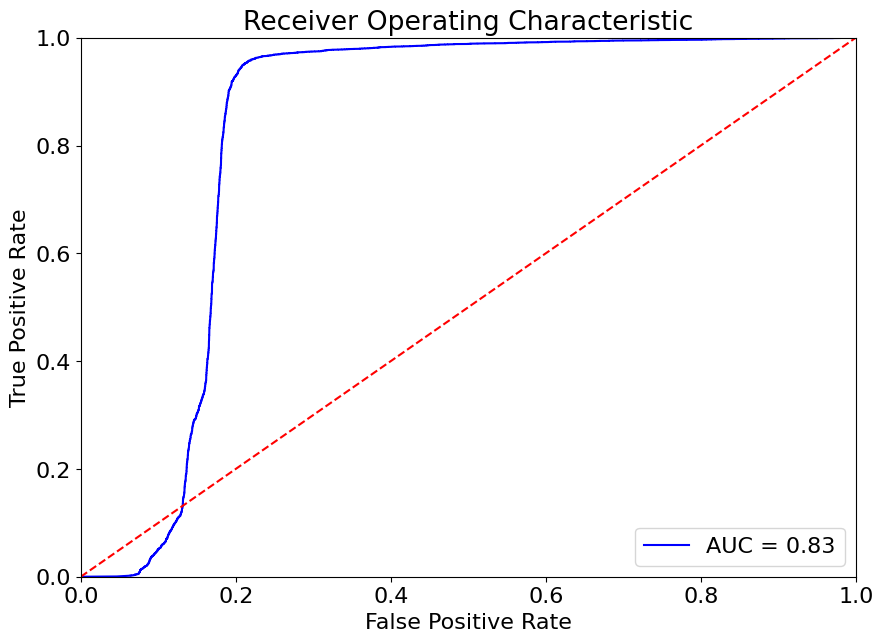

In [70]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_train,
                                         y_pred_proba_train)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*pada data test*

In [71]:
# Tampilkan confusion matrix
confusion_matrix(y_true = y_test,
                 y_pred = y_pred_test)

array([[1538,  463],
       [  27,  371]])

In [72]:
# Tampilkan score
accuracy_score(y_true = y_test,
               y_pred = y_pred_test)

0.7957482284285119

In [73]:
# Tampilkan score
print(classification_report(y_true = y_test,
                            y_pred = y_pred_test,
                            target_names = ["stay (0)", "left (1)"]))

              precision    recall  f1-score   support

    stay (0)       0.98      0.77      0.86      2001
    left (1)       0.44      0.93      0.60       398

    accuracy                           0.80      2399
   macro avg       0.71      0.85      0.73      2399
weighted avg       0.89      0.80      0.82      2399



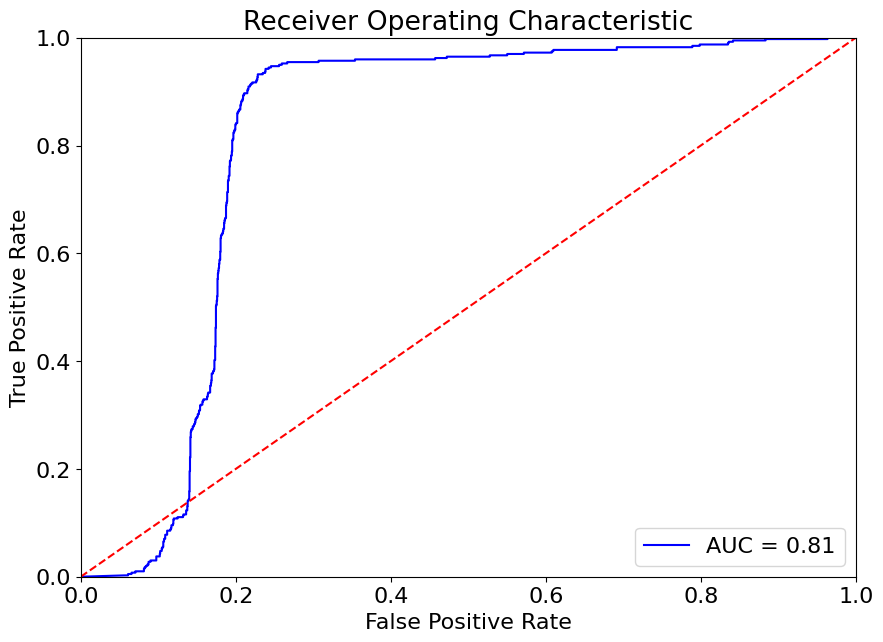

In [74]:
# ROC Curve
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test,
                                         y_pred_proba_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()